## Setup of the Environment

The only missing package is most likely Jellyfish, which provides support for string matching and offers such phonetic distance functions that we will need below. For further details, see the [Jellyfish homepage](https://pypi.python.org/pypi/jellyfish). The package can be installed by running the following command.

In [1]:
!pip install jellyfish

In [2]:
# The %... is an iPython thing, and is not part of the Python language.
# In this case we're just telling the plotting library to draw things on
# the notebook, instead of on a separate window.
%matplotlib inline

# See all the "as ..." contructs? They're just aliasing the package names.
# That way we can call methods like plt.plot() instead of matplotlib.pyplot.plot().
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

import itertools
import os.path
from datetime import datetime # for time measurement
import sys
import os
import pickle
import gzip
import math
import codecs

from jellyfish import jaro_distance, jaro_winkler, hamming_distance, levenshtein_distance
import scipy.cluster.hierarchy as scipycluster
from sklearn.feature_extraction.text import TfidfVectorizer

from scipy.spatial import distance
# import the k-means algorithm
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import pairwise_distances_argmin,pairwise_distances_argmin_min, pairwise_distances
from sklearn.metrics.pairwise import euclidean_distances

def printLog(text):
    now=str(datetime.now())
    print("["+now+"]\t"+text)
    # forces to output the result of the print command immediately, see: http://stackoverflow.com/questions/230751/how-to-flush-output-of-python-print
    sys.stdout.flush()
    
def pickleCompress(fileName,pickledObject):
    printLog("Pickling to '%s'" %fileName)
    f = gzip.open(fileName,'wb')
    pickle.dump(pickledObject,f)
    f.close()
    printLog("Pickling done.")
    
def pickleDecompress(fileName):
    #restore the object
    printLog("Depickling from '%s'" %fileName)
    f = gzip.open(fileName,'rb')
    pickledObject = pickle.load(f)
    f.close()
    printLog("Depickling done.")
    return pickledObject

## Simple Clustering Example

In [3]:
words = u'Berlin Balin Cölln Köln'.split()
print(words)

print("Number of words: %i" % len(words))
for i,val in enumerate(words):
    print(str(i)+":\t "+str(val))

['Berlin', 'Balin', 'Cölln', 'Köln']
Number of words: 4
0:	 Berlin
1:	 Balin
2:	 Cölln
3:	 Köln


One way to do this is to use the __jaro\_distance()__ provided by the Jellyfish pacakge (see above).
Unfortunately, the name of the function is quite misleading as it technically computes a similarity as illustrated below. A distance between two equal strings would be 0...

In [4]:
jaro_distance(u'Berlin',u'Berlin')

1.0

In order to determine the dissimilarity between each city name, we compute a so-called distance matrix. A square matrix whose diagonal is 0 as the distance between the same city name is 0 for obvious reasons. Each column and row of the matrix corresponds to a name pair. For instance, the first column stands for Berlin, the third row for Cölln.

In [5]:
# http://docs.scipy.org/doc/numpy-1.10.1/reference/generated/numpy.triu_indices.html
# 2nd parameter:
# Diagonal above which to zero elements. k = 0 (the default) is the main diagonal, k < 0 is below it and k > 0 is above."""
# r= Return the indices for the upper-triangle of an (n, m) array. da m nicht angegeben ist, wird n=m angenommen
# m is not passed, hence m=n

# create a square matrix
r=np.triu_indices(n=len(words), k=1)
r

(array([0, 0, 0, 1, 1, 2]), array([1, 2, 3, 2, 3, 3]))

Our distance matrix is structured as follows:
$$
A=
\begin{pmatrix}
a_{0,0} & \underline{a_{0,1}} & \underline{a_{0,2}} & \underline{a_{0,3}} \\
\cdot & a_{1,1} & \underline{a_{1,2}} & \underline{a_{1,3}} \\
\cdot & \cdot & a_{2,2} & \underline{a_{2,3}} \\
\cdot & \cdot & \cdot & a_{3,3}
\end{pmatrix}
$$

To give an example, $a_{0,1}$ yields the difference between "Berlin" and "Balin".

In [6]:
def d_demo(coord):
    print(coord)
    i, j = coord
    # 1-distance is needed as the function yields a similarity (see above)
    return 1-jaro_distance(words[i], words[j])

In [7]:
# http://docs.scipy.org/doc/numpy-1.10.1/reference/generated/numpy.set_printoptions.html
np.set_printoptions(precision=4)

# axis (3rd parameter): 0= along y axis, 1= along x axis
r2=np.apply_along_axis(d_demo, 0, r)
r2

[0 1]
[0 2]
[0 3]
[1 2]
[1 3]
[2 3]


array([0.1778, 0.4222, 0.3889, 0.4   , 0.3667, 0.2167])

If we map the resulting array back to a matrix, we obtain:
$$
A=
\begin{pmatrix}
a_{0,0} & \underline{0.1778} & \underline{0.4222} & \underline{0.3889} \\
\cdot & a_{1,1} & \underline{0.4} & \underline{0.3667} \\
\cdot & \cdot & a_{2,2} & \underline{0.2167} \\
\cdot & \cdot & \cdot & a_{3,3}
\end{pmatrix}
$$

That is, $a_{0,1}$, the difference between "Berlin" and "Balin", is 0.17777778. In other words, the strings are fairly similar (there is a low distance between them).

## Working with Real Data

First, we have to define the distance function to build our distance matrix.

In [11]:
def d(coord):
    #print(coord)
    i, j = coord
    #py27 return 1-jaro_distance(unicode(str(words[i]), 'utf-8'), unicode(str(words[j]), 'utf-8'))
    return 1-jaro_distance(words[i],words[j])

In [17]:
words=['Neon-Phaliron','Neon-Phalirou','Temesvár','Temeswar','Kolozsvártt','Kolozsvár','Kiøbenhavn','Kiøbenhavn','Kjøbenhavn','Kjøbenhavn','Kjöbenhavn','Kjøbenhavn','Kiøbenhavn','København','Kopenhagen','Copenhagen','Berlin','Bern','Berlino','Frankfurt/Main', 'Frankfurt/Oder', 'Frankfurt, Main',
       'Frankfurt, O', 'Frankfurt, Oder', 'Franckfurt', 'Franckfurth',
       'Frankfurt a. M.', 'Frankfurt', 'Frankfurt/ Main',
       'Frankfurt a.M.', 'Frankfurt, Oder?', 'Frankfurt a. O.','Francofurti','Lipsiae','Lipsiæ','Leipzig','Havniæ','Hanoviae','Hanoviae','Obernai','Oberhofen','Bernburg','Berlin-Dahlem','Steglitz-Berlin']
words

['Neon-Phaliron',
 'Neon-Phalirou',
 'Temesvár',
 'Temeswar',
 'Kolozsvártt',
 'Kolozsvár',
 'Kiøbenhavn',
 'Kiøbenhavn',
 'Kjøbenhavn',
 'Kjøbenhavn',
 'Kjöbenhavn',
 'Kjøbenhavn',
 'Kiøbenhavn',
 'København',
 'Kopenhagen',
 'Copenhagen',
 'Berlin',
 'Bern',
 'Berlino',
 'Frankfurt/Main',
 'Frankfurt/Oder',
 'Frankfurt, Main',
 'Frankfurt, O',
 'Frankfurt, Oder',
 'Franckfurt',
 'Franckfurth',
 'Frankfurt a. M.',
 'Frankfurt',
 'Frankfurt/ Main',
 'Frankfurt a.M.',
 'Frankfurt, Oder?',
 'Frankfurt a. O.',
 'Francofurti',
 'Lipsiae',
 'Lipsiæ',
 'Leipzig',
 'Havniæ',
 'Hanoviae',
 'Hanoviae',
 'Obernai',
 'Oberhofen',
 'Bernburg',
 'Berlin-Dahlem',
 'Steglitz-Berlin']

In [18]:
r=np.triu_indices(len(words), 1)

In [19]:
printLog("Started calculation of distance matrix for %i words..."%len(words))
# _ is the last evaluated value in an interactive shell
# axis (3rd parameter): 0= along y axis, 1= along x axis
r2=np.apply_along_axis(d, 0, r)
printLog("Finished calculations.")

[2020-11-20 19:36:54.594918]	Started calculation of distance matrix for 44 words...
[2020-11-20 19:36:54.605143]	Finished calculations.


First, we give agglomerative/hierarchical clustering a try. For details, see https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.cluster.hierarchy.linkage.html .

In [20]:
Z=scipycluster.linkage(r2)

A 4 by (n-1) matrix Z is returned. At the i-th iteration, clusters with indices Z[i, 0] and Z[i, 1] are combined to form cluster n + i. A cluster with an index less than n corresponds to one of the n original observations. The distance between clusters Z[i, 0] and Z[i, 1] is given by Z[i, 2]. The fourth value Z[i, 3] represents the number of original observations in the newly formed cluster.

The result of the clustering algorithm can serve as input for a dendrogram plot, e.g., as described by
https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/.

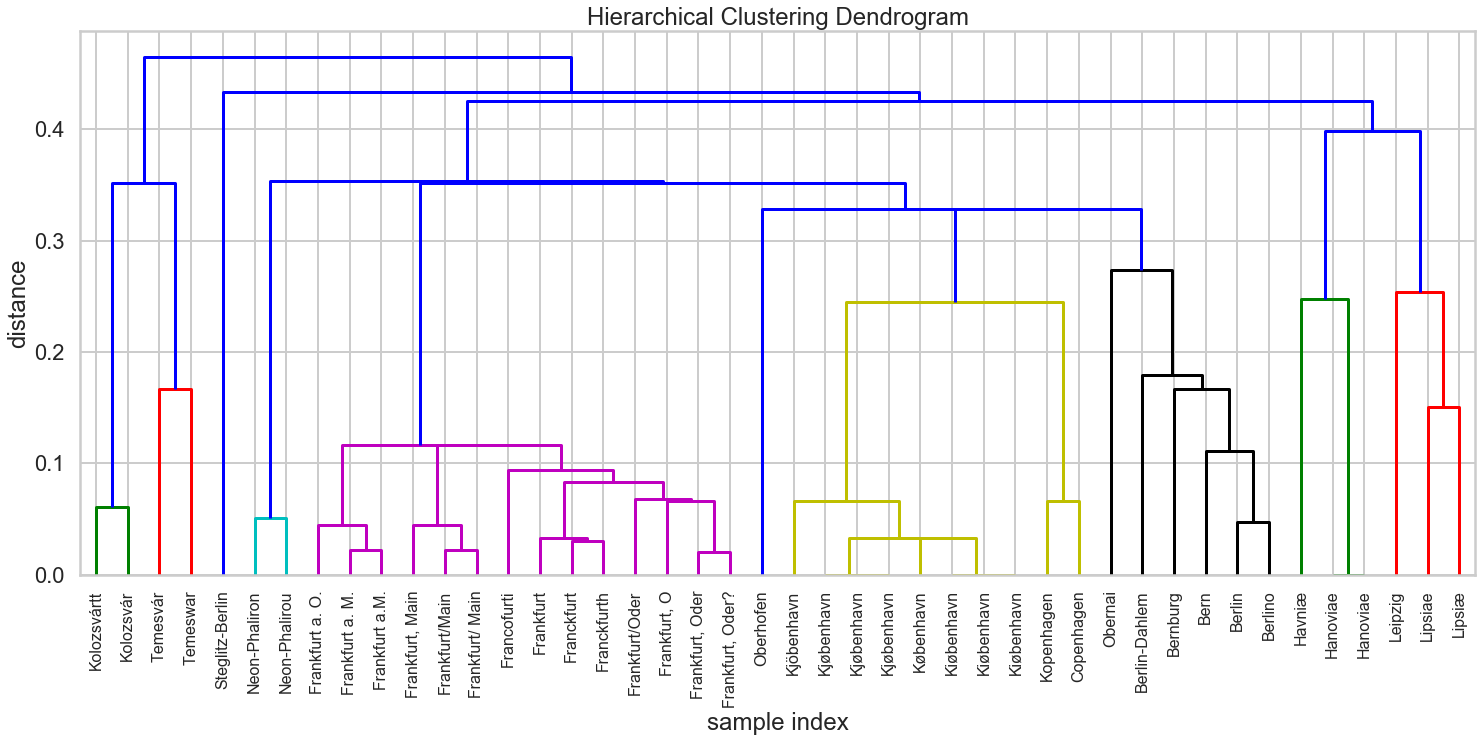

In [21]:
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
scipycluster.dendrogram(
        Z,
        leaf_rotation=90.,  # rotates the x axis labels
        leaf_font_size=16.,  # font size for the x axis labels
    labels=words
    )
plt.show()